In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', **{'size' : 18})

## 4. Prelucrarea setului de date

In [8]:
train_set = pd.read_csv('mnist_train.csv').values
test_set = pd.read_csv('mnist_test.csv').values

Procesarea presupune separarea primului element din fiecare linie ca fiind eticheta $y$. Vom face acelaşi lucru şi pentru setul de train şi pentru cel de test:

In [9]:
train_x, train_y = train_set[:, 1:], train_set[:, 0]
test_x, test_y = test_set[:, 1:], test_set[:, 0]

# verificăm că setul de train este separat în sample-uri şi etichete:
assert train_x.shape == (59999, 784)
assert train_y.shape == (59999,)

# la fel şi pentru setul de test:
assert test_x.shape == (9999, 784)
assert test_y.shape == (9999,)

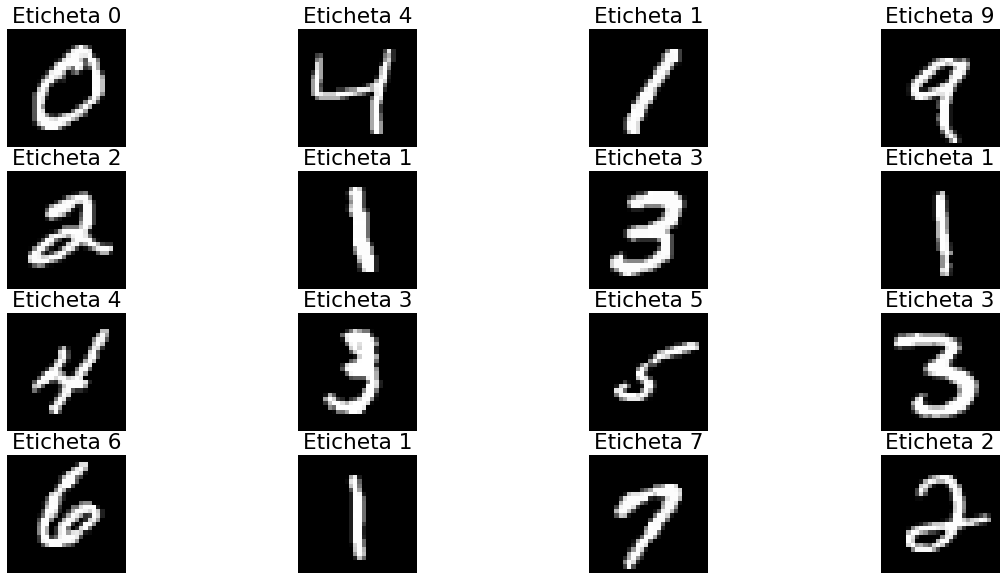

In [10]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16], train_y[:16])

In [11]:
def normalize(x):
    """
    Normalizarea înseamnă împărţirea cu 255
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
    
    Returns:
        matricea cu valorile normalizate in in [0, 1], dimensiune m x n
    """
    return x / 255.0

In [12]:
# în urma normalizării depunem rezultatele în aceleaşi variabile (le suprascriem)
train_x, test_x = normalize(train_x), normalize(test_x)

# valorile sample-urilor vor fi constrânse în intervalul [0, 1]
assert np.all(np.bitwise_and(train_x >= 0., train_x <= 1.))
assert np.all(np.bitwise_and(test_x >= 0., test_x <= 1.))

Deoarece folosim funcţia cross-entropy pentru antrenare, vom encoda cu 'one-hot encoding' etichetele. Matricea train_y se va transforma dintr-o matrice de dimensiune $(m, 1)$ în una de dimensiuni $(m, k)$, unde $k = 10$ (avem 10 clase).

In [13]:
def single_hot(p, k):
    """ 
    Single-hot encoding converteste o eticheta, de exemplu 7, in [0 0 0 0 0 0 0 1 0 0]
    
    Args:
        p: pozitia pe care se pune "1"
        k: numarul total de clase (lungimea listei generate)
    
    Returns:
        lista de zero-uri cu pozitia p setata pe 1
    """
    hot = np.zeros(k)
    hot[p] = 1
    return hot

def one_hot(set_y, k):
    """
    One-hot encoding converteste un intreg set la o forma matriciala.
    Foloseste implemetarea lui single-hot.
    
    Args:
        set_y: vector de dimensiune (m,)
        k: numarul de clase
        
    Returns:
        matricea de dimensiune (m, k), o linie reprezentind encodarea fiecarei etichete
    """
    return np.array([single_hot(set_y[i], k) for i in range(set_y.size)])

train_y = one_hot(train_y, 10)
test_y = one_hot(test_y, 10)

# verificam dimensiunile
assert train_y.shape == (train_x.shape[0], 10)
assert test_y.shape == (test_y.shape[0], 10)

# verificam ca pe fiecare linie sa avem doar un 1 si restul zero-uri
assert np.all(train_y.sum(axis=1) == 1)
assert np.all(test_y.sum(axis=1) == 1)

In [15]:
def sigmoid(z):
    return np.tanh(z)

def sigmoid_derivative(z):
    return 1.0 - (np.tanh(z) ** 2)

def softmax(z):
    exp = np.exp(z - np.max(z,axis=1,keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

# verificam ca softmax-ul sa fie calculat corect
a = np.array([[1., 3, 4], [2, 7, 3]])
assert a.shape == softmax(a).shape
assert np.all(np.abs(softmax(a).sum(axis=1) - 1) < 1e-6)
assert softmax(a).sum(axis=1).shape == (2,)
del a

## 6. Implementarea propagării înainte (forward)

Scopul este să evaluăm strat cu strat întreaga reţea, pornind de la intrare. Activările primului strat sunt chiar sample-urile setului de date $X$.

Se vor calcula net-urile (z-urile) pentru fiecare strat:

$z = w \cdot a + b$, respectiv activarile următoare:

$a = sigmoid(z)$, respectiv funcţia $softmax()$ pentru ultimul strat.

De exemplu, intrarea $a_I$ are dimensiunea $(m, I)$. Ponderile primului strat $w_{JI}$ au dimensiunea $(J, I)$, deci activarea $a_J = f(a_I \cdot w_{JI}^T + b_{JI}^T)$ va avea dimensiunea $(m, J)$ - vom folosi înmulţirea matricială pentru calculul net-ului $z_{J}$.

In [16]:
import numpy as np

def forward(set_x, weights, biases):
    """
    Propagarea înainte prin reţea, cu calcularea net-urilor şi activărilor.
    Atenţie că activările de pe ultimul strat se calculează cu funcţia softmax() în loc de sigmoid().
    
    Args:
        set_x: setul de intrare de dimensiune (m, I)
        weights: lista de matrici de ponderi
        biases: lista de vectori de termeni liberi
        
    Returns:
        activations: lista de activari
        nets: lista de net-uri (z)
    """
    nets = []
    activations = [set_x]
    
    nets.append(activations[-1] @ weights[0].T + biases[0].T)
    activations.append(sigmoid(nets[-1]))      
        
    nets.append(activations[-1] @ weights[1].T + biases[1].T)
    activations.append(softmax(nets[-1]))
    
    return activations, nets

# Pentru testare. luam intrarea de dimensiune (3, 25). 3 va fi dimensiunea batch size-ului,
# iar I=25 este numarul de neuroni de pe primul strat.
inputs = np.ones((3, 25)) * 0.5
print(inputs.shape)

# Stratul ascuns are J=10 neuroni iar ultimul (softmax) are K=4.
weights = np.array([np.ones((10, 25)) * 0.2, np.ones((4, 10)) * 0.3])
print(weights[0].shape)
biases = [np.ones((10,)) * 0.1, np.ones((4,)) * 0.1]

activations, nets = forward(inputs, weights, biases)

# Pentru 3 straturi, se vor calcula 3 activări şi 2 net-uri în cele două liste rezultate:
assert len(activations) == 3
assert len(nets) == 2

# Verificam forma activarilor
assert activations[0].shape == inputs.shape == (3, 25)
assert activations[1].shape == (3, 10)
assert activations[2].shape == (3, 4)
assert np.abs(np.linalg.norm(activations[0]) - 4.330127) < 1e-6
assert np.abs(np.linalg.norm(activations[1]) - 5.4171262) < 1e-6
assert np.abs(np.linalg.norm(activations[2]) - 0.8660254) < 1e-6

# Verificam forma net-urilor
assert nets[0].shape == (3, 10)
assert nets[1].shape == (3, 4)
assert np.abs(np.linalg.norm(nets[0]) - 14.2407865) < 1e-6
assert np.abs(np.linalg.norm(nets[1]) - 10.6246844) < 1e-6

(3, 25)
(10, 25)


## 7. Implementarea propagării înapoi (backward propagation)

Propagarea înapoi are drept scop calcularea gradientului pentru fiecare strat. Pentru aceasta, va trebui să determinăm $\delta$ asociat pentru fiecare strat începând de la ultimul.

Atenţie că aceşti $\delta$ nu sunt vectori coloană, ci matrici, cu prima dimensiune dimensiunea batch-ului şi a doua dimensiune dimensiunea stratului. Pe baza lui $\delta$ veţi determina gradientul, prin medierea folosind dimensiunea batch-ului (prima dimensiune).

O complicaţie din cauza dimensiunii batch-ului apare la următoarea relaţie:

$\delta_{a_J} = \left( \delta_{a_K} w_{KJ} \right) \odot f'(z_j)$

Aici, $\delta_{a_K}$ are dimensiunea $(m, K)$ iar prin înmulţirea cu $w_{KJ}$ se generează o matrice de dimensiuni $(m, J)$, aceleaşi cu cele ale lui $f'(z_j)$.

O a doua complicaţie apare tot din cauza dimensiunii batch-ului la relaţiile de calcul a gradientului:

$\nabla_{w_{JI}} E = \delta_{a_J} \cdot a_I$

Aici, $\delta_{a_J}$ are dimensiunea $(m, J)$ iar $a_I$, $(m, I)$. Pentru a înmulţi primii $m$ vectori coloană cu ceilalţi $m$ vectori linie, folosim batch matrix multiplication - înmulţire normală de matrici doar pentru ultimele două dimensiuni, pentru fiecare element din dimensiunea 0. Adică redimensionăm $(m, J) \rightarrow (m, J, 1)$ iar $(m, I) \rightarrow (m, 1, I)$, iar prin înmulţirea lor matricială obţinem $(m, J, I)$. Reducem prin mediere prima dimensiune.

In [17]:
def backward(weights, biases, activations, nets, set_y):
    """
    Propagă delta spre intrarea reţelei începând de la ultimul strat
    
    Args:
        weights: lista de ponderi
        biases: lista de elemente libere
        activations: lista de activari, calculata de forward
        nets: lista de z-uri, calculata de forward
        set_y: etichetele, one-hot encodate
        
    Returns:
        delta_w, delta_b: update-urile gradientilor
    """
    # declara delta-urile
    delta_b = [np.zeros(b.shape) for b in biases]
    delta_w = [np.zeros(w.shape) for w in weights]
    
    delta_a = [activations[-1] - set_y]
    delta_a.insert(0, np.matmul(delta_a[0], weights[1]) * sigmoid_derivative(nets[0]))
    
    for i in range(1, len(activations)):
        l = len(activations) - i - 1
        
        delta_aJ = delta_a[l].reshape(delta_a[l].shape[0], delta_a[l].shape[1], 1)
        aI = activations[l].reshape(activations[l].shape[0], 1, activations[l].shape[1])
        
        delta_w[l] = np.matmul(delta_aJ, aI).mean(axis=0)  
        delta_b[l] = np.mean(delta_a[l], axis=0)
        
        assert delta_w[l].shape == weights[l].shape
        assert delta_b[l].shape == biases[l].shape
        
    return delta_w, delta_b

# declaram niste etichete de test si aplicam metoda
labels = one_hot(np.array([1, 0, 3]), 4)

delta_w, delta_b = backward(weights, biases, activations, nets, labels)

# verificam consistenta raspunsurilor
assert len(delta_w) == len(delta_b) == 2
assert delta_w[0].shape == (10, 25)
assert delta_w[1].shape == (4, 10)
assert delta_b[0].shape == (10,)
assert delta_b[1].shape == (4,)
assert np.linalg.norm(delta_w[0]) < 1e-15
assert np.abs(np.linalg.norm(delta_w[1]) - 0.9028543) < 1e-6
assert np.linalg.norm(delta_b[0]) < 1e-15
assert np.abs(np.linalg.norm(delta_b[1]) - 0.2886751) < 1e-6

## 8. Calculul unui batch şi a acurateţii

Constă din propagarea înainte, propagarea înapoi, urmate de ajustarea ponderilor.

In [18]:
def compute_batch(batch_x, batch_y, weights, biases, eta, lmbda):
    """ 
    Realizeaza cei doi pasi pentru fiecare batch in parte
    
    Args:
        batch_x: sample-urile de intrare
        batch_y: etichetele lor
        weights: lista cu ponderile reţelei
        biases: lista cu termenii liberi
        eta: rata de învăţare
        lmbda: parametrul de regularizare
        
    Returns:
        weights, biases: noile ponderi după actualizarea lor cu gradienţii calculaţi
    """
    activations, nets = forward(batch_x, weights, biases)
    delta_w, delta_b = backward(weights, biases, activations, nets, batch_y)

    # Pentru fiecare parametru din lista se realizeaza:
    # weight <-- weight - eta * (grad_w + lambda * weight)
    # bias <-- bias - eta * grad_b
    weights = [weight - eta * (grad_w + lmbda * weight) for weight, grad_w in zip(weights, delta_w)]
    biases = [bias - eta * grad_b for bias, grad_b in zip(biases, delta_b)]
    
    return weights, biases

Acurateţea presupune inspectarea etichetelor şi compararea lor cu rezultatul produs de reţea:

In [19]:
def accuracy(set_x, set_y, weights, biases):
    """ 
    Calculeaza iesirea sub forma de one-hot encoding folosind feedforward(),
    si o foloseste pentru a numara cate sample-uri sunt antrenate corect
    
    Args:
        set_x: sample-urile, de dimensiune (m, n)
        set_y: etichetele, de dimensiune (m, k)
        weights: lista ponderilor reţelei
        biases: lista termenilor liberi
        
    Returns:
        procentul de sample-uri clasificate corect
    """
    # ... call forward() 
    activations, _ = forward(set_x, weights, biases)
    res = np.argmax(activations[-1], axis=1) == np.argmax(set_y, axis=1) 
    return 100 * res.sum() / len(res)

assert np.abs(accuracy(inputs, labels, weights, biases) - 33.3333333) < 1e-6

## 9. Antrenarea reţelei şi evaluarea pe setul de test

In [14]:
sizes = [28 * 28, 100, 10]
scale = 1 / np.sqrt(train_x.shape[0])

weights = [np.random.normal(loc=0, scale=scale, size = (j, i)) for i, j in zip(sizes[:-1], sizes[1:])]
biases = [np.random.normal(loc=0, scale=scale, size = (i,)) for i in sizes[1:]]

eta = 0.2
batch_size = 20 # pentru aceasta dimensiune de batch, consumul de memorie este la 1.5 GB
lmbda = 0.001
epochs = 10

for epoch in range(epochs):
    # generarea unei permutari aleatoare a sample-urilor din set
    perm = np.random.permutation(train_x.shape[0])
    
    # generarea batch-urilor folosind acea permutare aleatoare
    x_batches = [train_x[perm[index : index + batch_size]] for index in range(0, train_x.shape[0], batch_size)]
    y_batches = [train_y[perm[index : index + batch_size]] for index in range(0, train_x.shape[0], batch_size)]

    # rularea batch-urilor si schimbarea ponderilor retelei
    for (batch_x, batch_y) in zip(x_batches, y_batches):
        weights, biases = compute_batch(batch_x, batch_y, weights, biases, eta, lmbda)
        
    print(f'epoch: {epoch}, eta: {eta:.2f}, train accuracy: {accuracy(train_x, train_y, weights, biases):.2f}')
    
    eta *= 0.8

epoch: 0, eta: 0.20, train accuracy: 95.23
epoch: 1, eta: 0.16, train accuracy: 96.40
epoch: 2, eta: 0.13, train accuracy: 97.06
epoch: 3, eta: 0.10, train accuracy: 97.12
epoch: 4, eta: 0.08, train accuracy: 97.53
epoch: 5, eta: 0.07, train accuracy: 97.78
epoch: 6, eta: 0.05, train accuracy: 97.84
epoch: 7, eta: 0.04, train accuracy: 97.94
epoch: 8, eta: 0.03, train accuracy: 97.95
epoch: 9, eta: 0.03, train accuracy: 97.98


In [15]:
# acuratetea pe setul de test
accuracy(test_x, test_y, weights, biases)

97.2897289728973